# VGG comparison with and without BatchNorm 

In [122]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

## Constants (parameters) initialization

In [40]:
device_id = 0
num_workers = 4

batch_size = 128
default_learning_rate = 0.1

## CIFAR-10 data load and preproc

In [41]:
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import PIL.Image as Image
from torch import nn
import numpy as np
import torch.optim as optim
import pandas as pd
import torch
from torchvision import transforms, utils
import torchvision.models as models
import torchvision.datasets as datasets
import os
import sys
import random
from tqdm import tqdm as tqdm
from IPython import display
import importlib

In [150]:
# add our package dir to path 
module_path = os.path.dirname(os.getcwd())
sys.path.append(module_path)

home_path = module_path
figures_path = os.path.join(home_path, 'reports', 'figures')
models_path = os.path.join(home_path, 'reports', 'models')

Make sure we are using the right device.

In [43]:
device_id = device_id
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]=str(device_id)

device = torch.device("cuda:{}".format(device_id) if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device_id))

cuda:0
GeForce GTX 1080 Ti


In [44]:
from src.data.loaders import get_cifar_loader

In [45]:
train_loader = get_cifar_loader(batch_size=batch_size, train=True)
val_loader = get_cifar_loader(batch_size=batch_size, train=False)

Files already downloaded and verified
Files already downloaded and verified


Make sure that dataloader works as expected by observing one sample from it.

tensor([[[-0.8431, -0.8588, -0.8588,  ..., -0.1373, -0.6000, -0.8431],
         [-0.5373, -0.8118, -0.8745,  ..., -0.0196, -0.4588, -0.8196],
         [-0.4431, -0.7804, -0.8667,  ..., -0.3098, -0.3961, -0.7098],
         ...,
         [-0.4902, -0.4196, -0.3333,  ..., -0.8196, -0.6863, -0.4118],
         [-0.7412, -0.5059, -0.2706,  ..., -0.9216, -0.9529, -0.8980],
         [-0.7020, -0.7255, -0.4745,  ..., -0.9059, -0.9059, -0.8745]],

        [[-0.8275, -0.8745, -0.8667,  ..., -0.0118, -0.5137, -0.7882],
         [-0.4431, -0.7725, -0.8667,  ...,  0.1137, -0.3569, -0.7490],
         [-0.3255, -0.7020, -0.8118,  ..., -0.2157, -0.3176, -0.6392],
         ...,
         [-0.3176, -0.2392, -0.1608,  ..., -0.7333, -0.5451, -0.2549],
         [-0.6078, -0.3569, -0.1294,  ..., -0.8667, -0.8588, -0.8039],
         [-0.6157, -0.6392, -0.3961,  ..., -0.8588, -0.8588, -0.8667]],

        [[-0.8902, -0.7882, -0.7961,  ..., -0.7255, -0.8667, -0.8667],
         [-0.8588, -0.8588, -0.7882,  ..., -0

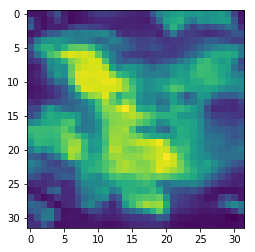

In [54]:
for X,y in train_loader:
    print(X[0])
    print(y[0])
    print(X[0].shape)
    plt.imshow(np.array(X[0,0,:,:]))
    print(X[0].max())
    print(X[0].min())
    break

## Init model

In [47]:
def get_number_of_parameters(model):
    parameters_n = 0
    for parameter in model.parameters():
        parameters_n += np.prod(parameter.shape).item()
        
    return parameters_n

In [74]:
import src.models.vgg as vgg
importlib.reload(vgg)

<module 'src.models.vgg' from '/mnt/bulky/abauman/projects/batch_norm_helps_optimization/src/models/vgg.py'>

In [75]:
model = vgg.VGGA()
get_number_of_parameters(model)

9750922

In [80]:
model = vgg.VGGABatchNorm()
get_number_of_parameters(model)

9758474

## Final preparations for training

In [113]:
def train(model, 
          optimizer, 
          criterion,  
          train_loader, 
          val_loader, 
          scheduler=None, 
          epochs_n=100, 
          best_model_path=None):
    
    model.to(device)
    learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    batches_n = len(train_loader)

    for epoch in tqdm(range(epochs_n), unit='epoch'):
        if scheduler is not None:  
            scheduler.step()       
        model.train()

        learning_curve[epoch] = 0
        for data in train_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            learning_curve[epoch] += loss.item()
            loss.backward()
            optimizer.step()
        
        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        learning_curve[epoch] /= batches_n
        axes[0].plot(learning_curve)

        model.eval()
        train_accuracy_curve[epoch] = get_accuracy(model, train_loader, device)
        val_accuracy_curve[epoch] = get_accuracy(model, val_loader, device)
        
        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch
            if best_model_path:
                torch.save(model.state_dict(), best_model_path)
        
        axes[1].set_title('Train {:.4f}, val {:.4f}, max val {:.4f} at {}'.format(
            train_accuracy_curve[epoch], val_accuracy, max_val_accuracy, max_val_accuracy_epoch))
        axes[1].plot(train_accuracy_curve)
        axes[1].plot(val_accuracy_curve)

        plt.tight_layout()
        plt.show()
        
    return learning_curve, train_accuracy_curve, val_accuracy_curve

In [114]:
def get_accuracy(model, dataloader, device='cpu'):
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)  ## <---
            y = y.to(device)  ## <---
            prediction = model(x).argmax(dim=-1, keepdim=True)
            correct += prediction.eq(y.view_as(prediction)).sum().item()
    return correct / len(dataloader.dataset)

In [115]:
def set_random_seeds(seed_value=0, device='cpu'):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

## Perform training VGG without and with BatchNorm

In [117]:
training_results = {}

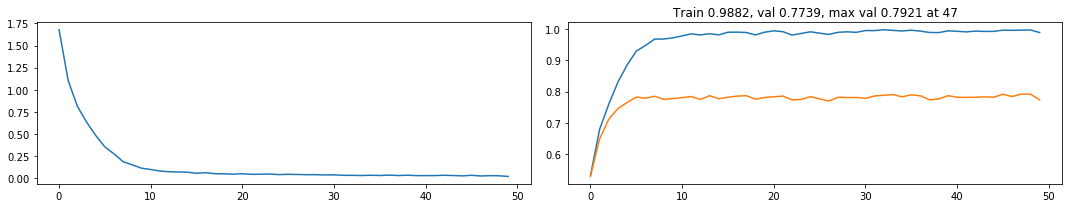

















100%|██████████| 50/50 [12:40<00:00, 15.16s/epoch]

In [118]:
lr = 5e-4
model_name = 'vgg'
experimment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experimment_name}.pt') #change dump name here

set_random_seeds(seed_value=1984, device=device)
model = vgg.VGGA()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results[experimment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=50, 
                                           best_model_path=model_path)

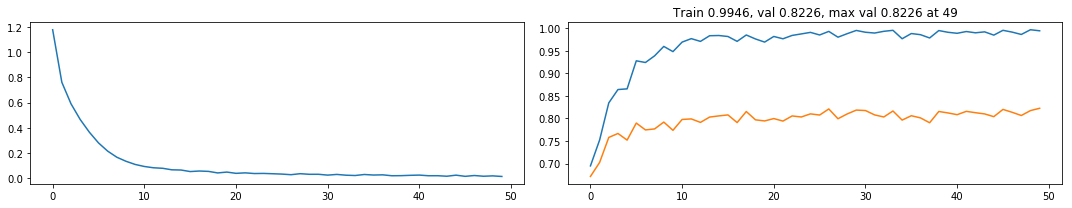

















100%|██████████| 50/50 [13:35<00:00, 16.13s/epoch]

In [119]:
lr = 5e-4
model_name = 'vgg_bn'
experimment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experimment_name}.pt') #change dump name here

set_random_seeds(seed_value=1984, device=device)
model = vgg.VGGABatchNorm()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results[experimment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=50, 
                                           best_model_path=model_path)

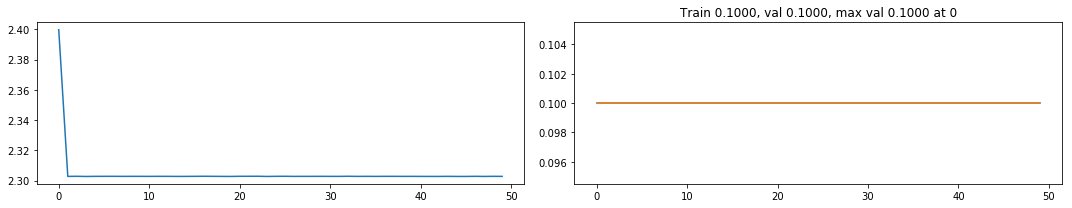

















100%|██████████| 50/50 [12:25<00:00, 14.85s/epoch]

In [120]:
lr = 3e-3
model_name = 'vgg'
experimment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experimment_name}.pt') #change dump name here

set_random_seeds(seed_value=1984, device=device)
model = vgg.VGGA()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results[experimment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=50, 
                                           best_model_path=model_path)

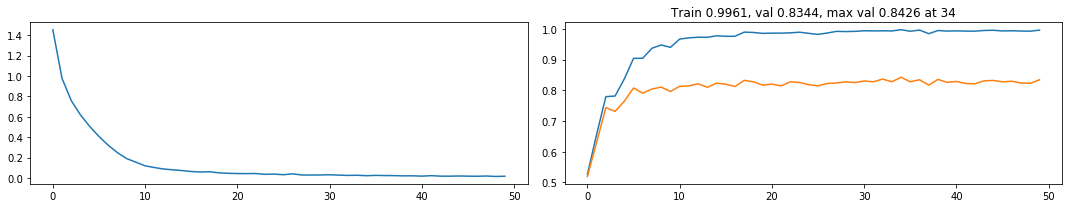

















100%|██████████| 50/50 [13:33<00:00, 16.28s/epoch]

In [121]:
lr = 3e-3
model_name = 'vgg_bn'
experimment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experimment_name}.pt') #change dump name here

set_random_seeds(seed_value=1984, device=device)
model = vgg.VGGABatchNorm()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results[experimment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=50, 
                                           best_model_path=model_path)

## Plot results

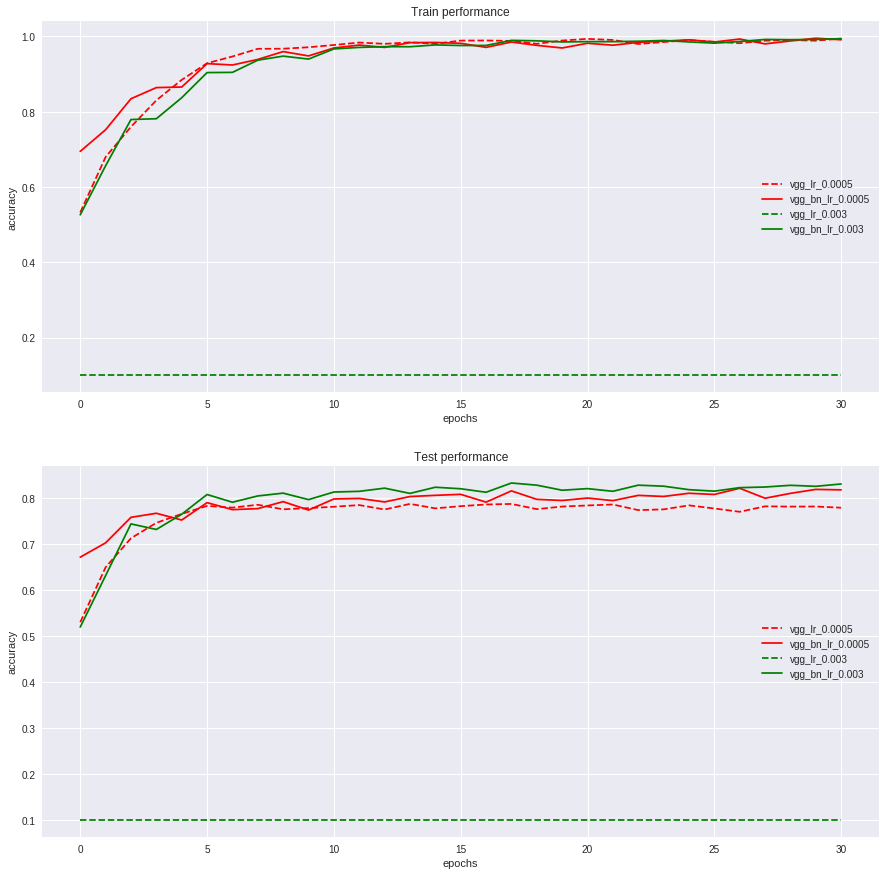

In [151]:
fig, axs = plt.subplots(2, 1, figsize=(15, 15))

for exp_name, result in training_results.items():
    learning_curve, train_accuracy_curve, val_accuracy_curve = result
    
    if '0.0005' in exp_name:
        if 'bn' in exp_name:
            axs[0].plot(train_accuracy_curve[:31], 'r', label=exp_name)
            axs[1].plot(val_accuracy_curve[:31], 'r', label=exp_name)
        else:
            axs[0].plot(train_accuracy_curve[:31], 'r--', label=exp_name)
            axs[1].plot(val_accuracy_curve[:31], 'r--', label=exp_name)
    elif '0.003' in exp_name:
        if 'bn' in exp_name:
            axs[0].plot(train_accuracy_curve[:31], 'g', label=exp_name)
            axs[1].plot(val_accuracy_curve[:31], 'g', label=exp_name)
        else:
            axs[0].plot(train_accuracy_curve[:31], 'g--', label=exp_name)
            axs[1].plot(val_accuracy_curve[:31], 'g--', label=exp_name)

axs[0].set_title('Train performance')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('accuracy')
axs[0].legend()

axs[1].set_title('Test performance')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
axs[1].legend()
plt.savefig(os.path.join(figures_path, 'comparison_bn.png'), dpi=500, quality=100)
plt.show()